IS6400 21/22 Semester B

- Week 6: Regression

Zhiya Zuo (zhiyazuo@cityu.edu.hk)

Department of Information Systems

City University of Hong Kong

---

In [1]:
import numpy as np
from scipy import stats as SP_STATS
import pandas as pd

In [2]:
from sklearn import linear_model

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm
#%matplotlib notebook
%matplotlib inline

---

# Why regression?

Regression is probably one of the most commonly adopted statistical techniques. Our first question, why regression, seems totally unnecessary given the prevalence of this approach. The central idea of regression is to try to predict the average outcome based on a given set of variables.

It is important to emphasize the adjective _average_ in this brief description here.
Instead of trying to precisely capture idiosyncrasy for every single individual in the dataset, the objective of regression is to _make a compromise_ and produce predictions about how individuals may be like on average.

## The origins of _"regression"_

The first time this term appeared in the academia was 1886:
- Galton, F. (1886). Regression towards mediocrity in hereditary stature. The Journal of the Anthropological Institute of Great Britain and Ireland, 15, 246-263.

At the time, Galton discovered that there is a correlation between children and their parents. Moreover, the deviation of children's heights from the mean is expeceted to be less than that of their parents.

In [4]:
mother_daughter_heights_url = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/PearsonLee/data/MotherDaughterHeights.txt"

In [5]:
mother_daughter_heights_dat = pd.read_csv(mother_daughter_heights_url, sep=' ')
mother_daughter_heights_dat.head()

,daughter_height,mother_height
1,52.5,59.5
2,52.5,59.5
3,53.5,59.5
4,53.5,59.5
5,55.5,59.5


In [6]:
X = mother_daughter_heights_dat.loc[:, ['mother_height']].values
y = mother_daughter_heights_dat.loc[:, 'daughter_height'].values
X.shape, y.shape

((5524, 1), (5524,))

In [7]:
mother_daughter_heights_lr = linear_model.LinearRegression()
mother_daughter_heights_lr = mother_daughter_heights_lr.fit(X, y)
beta_1, beta_0 = mother_daughter_heights_lr.coef_, mother_daughter_heights_lr.intercept_
print('Slope:%.2f\nIntercept: %.2f'%(beta_1, beta_0))

Slope:0.54
Intercept: 29.80


In [8]:
y_pred = beta_1 * X[:,0] + beta_0

In [9]:
# they share the same mean
print('Predicted mean:', np.mean(y_pred))
print('Observed mean: ', np.mean(y))

Predicted mean: 63.85626357711803
Observed mean:  63.85626357711803


In [10]:
X_fitted = np.linspace(0, 70, 100)
y_fitted = beta_1 * X_fitted + beta_0

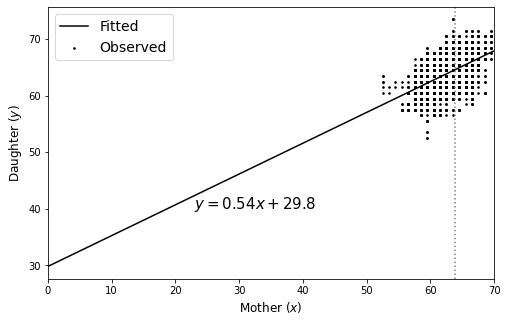

In [11]:
fig, ax = plt.subplots(figsize=[8,5])
ax.set_xlim([0, 70])
ax.text(x=23, y=40, s=r'$y=0.54x+29.8$', fontsize=15)
ax.scatter(X[:,0], y, marker='.', s=10, color='k', label='Observed')
ax.plot(X_fitted, y_fitted, color='k', label='Fitted')
ax.axvline(x=np.mean(y), ls='dotted', color='gray')
ax.set_xlabel('Mother ($x$)', fontsize=12)
ax.set_ylabel('Daughter ($y$)', fontsize=12)
_ = ax.legend(prop={'size': 14}, loc=2)

As we can see in this figure, when mother's height is below (above) the line, the predicted daughter's height will be closer to (farther away from) the center (mean) of the observed data points. Consequently, the original use of the term "regression" was not to describe a staitical method but a description of his findings (a.k.a., regression to the mean). Gradually, the meaning of "regression" has already been expanded to refer to such line fitting approach for identifying linear relationships betwen variables.

## Use cases of regression

Regression as a powerful statistical analysis technique can be applied to accomplish different goals:
- _Prediction_: The most straightforward application of regression is probably prediction -- given past observations, we want to predict future values of a given target. Examples include the prediction of bitcoin prices, product sales, or election results. This is also the focus of our class today.
    - A cool example is the 2020 U.S. presidential election prediction conducted by [FiveThirtyEight](https://projects.fivethirtyeight.com/2020-election-forecast/).

- _Explanation_: In social sciences, researchers utilize regression approaches to understand correlations between variables of interests. For instance, many recent interests lie on the analysis of how social distancing affects the COVID-19 pandemic severity. Furthermore, since the credibility revolution in the field of economics, there has been strong emphasis on proper and rigorous identification of causal effects rather than simply association, the latter of which may oftentimes be misleading. Just for fun, many examples of [spurious correlations](http://tylervigen.com/spurious-correlations) are visualized.

## Regression vs. classification

Nowadays, we tend to clear distinguish two supervised learning tasks depending on the type of outcome variables:
- Regression is for prediction of continuous variables (e.g., height, population, price).
- Classification is for prediction of categorical variables (e.g., spam detection, car plate recognition).

Nonehtless, it is worth noting that classification can be thought of a specific case of regression. In the simple case of a binary prediction, for instance, a non-linear transformation can be applied on top of the linear regression model in order to produce values between 0 and 1. Such values can be interpreted as the probability of being 1 (a.k.a., having the positive class label).

As shall be seen later in the generalized linear model section, we can make use of sigmoid function:
$$ Sigmoid(x) = \dfrac{1}{1+e^{-x}} = \dfrac{e^x}{1+e^x} \in (0, 1)$$

In [12]:
x = np.linspace(-10, 10, 100)
x_sigmoid = 1. / (1 + np.exp(-x))

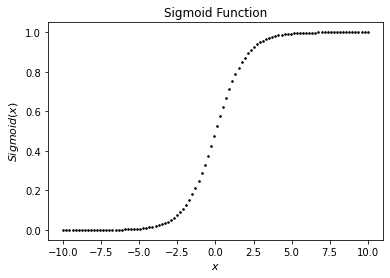

In [13]:
fig, ax = plt.subplots(figsize=[6,4])
ax.set_title('Sigmoid Function')
ax.scatter(x, x_sigmoid, marker='.', color='k', s=10)
ax.set_ylabel('$Sigmoid(x)$', size=11)
_ = ax.set_xlabel('$x$', size=11)

---

# Starting with simple linear regression

## Let's see how it works

The formulation of a simple linear regression is straighforward:
$$y = \beta_1 x + \beta_0 + \epsilon$$

where:
- $\beta_1$ is the regression slope capturing the correlation between $x$ and $y$
- $\beta_0$ is the regression intercept, i.e., the predicted value of $y$ when $x=0$
- $\epsilon$ is the random noise that our model is unable to capture. It is assumed that $\epsilon \sim \mathcal{N}(0, \sigma^2)$.
- Interpretation of the model is intuitive: an increase in one unit of $x$ is expected to be associated with $\beta_1$ unit increase in $y$.

## But how we learn the $\beta$'s?

Intuitively, we are trying to model our data - that is, we are trying to make this simple linear regression predict the target given a subject's information. 
A mathematically equivalent way to say this is that we want to minize the error the model can make. Put differently, we have an _objective function_ that we want to optimize (in this context, reaching the minimum):

$$ \mathcal{J}(\beta_1,\beta_0) = \frac{1}{2}\Sigma_{i}^{N} {\epsilon_i}^2 = \frac{1}{2}\Sigma_{i}^{N}[y_i-(\beta_1x_i+\beta_0)]^2$$

As a side comment - the $\frac{1}{2}$ is not necessary but just for mathmatical convenience later.

Here, we define function $\mathcal{J}(\cdot)$ to be a function of both the slope and the intercept, manfesting the fact that when different $\beta$'s are placed in the model, different error values will be achieved (i.e., different levels of model fit). Upon realizing that this is actually an optimization problem, we can further write down our target as below. But what is our next step?

$$ min \mathcal{J}(\beta_1,\beta_0) = min~\frac{1}{2}\Sigma_{i}^{N}[y_i-(\beta_1x_i+\beta_0)]^2$$

This is why the approach to parameter estimation of linear regression models is also called __least squares__!

How about we start by trying a grid of values? In other words, could we arbitrarily provide a bunch of candidate values for $\beta_1$ and $\beta_0$ as a trial-and-error approach? Let's try it

In [14]:
x = X[:, 0]

In [15]:
N = x.size
N == y.size

True

In [16]:
N_grid = 200
beta_1_cand = np.linspace(-100, 100, N_grid)
beta_0_cand = np.linspace(-100, 100, N_grid)
b1_grid, b0_grid = np.meshgrid(beta_1_cand, beta_0_cand)
b1_grid.shape, b0_grid.shape

((200, 200), (200, 200))

In [17]:
beta_error_dat = list()
J_list = list()
for i in range(N_grid):
    for j in range(N_grid):
        b1 = b1_grid[i,j]
        b0 = b0_grid[i,j]
        y_tmp = b1 * x + b0
        e_tmp = ((y_tmp - y)**2).sum()/2
        J_list.append(e_tmp)
        beta_error_dat.append([b1, b0, e_tmp])
beta_error_dat = pd.DataFrame(beta_error_dat, columns=['beta_1', 'beta_0', 'J'])
beta_error_dat.shape

(40000, 3)

Let's try to find out the best performing combinations

In [18]:
# print top 3
beta_error_dat.sort_values('J').head(3)

,beta_1,beta_0,J
26500,0.502513,32.663317,14282.137534
26300,0.502513,31.658291,15886.935393
26700,0.502513,33.668342,18256.996755


In [19]:
beta_grid = beta_error_dat.sort_values('J').iloc[0][['beta_1', 'beta_0']].values
J_grid = beta_error_dat.sort_values('J').iloc[0]['J']
beta_grid, J_grid

(array([ 0.50251256, 32.66331658]), 14282.137534405018)

And we can compare this manual approach with the built-in function by `sklearn`:

In [20]:
J_lr = ((y_pred - y)**2).sum()
J_lr

28254.918351280987

Well, pretty good! We can also visualize to see this in a clearer way:

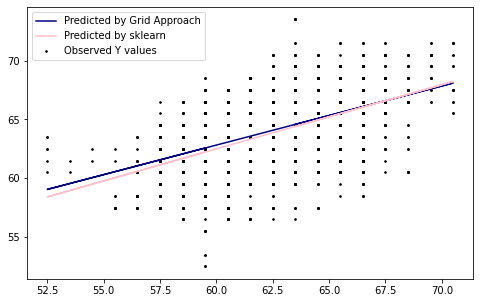

In [21]:
fig, ax = plt.subplots(figsize=[8, 5])
y_grid = x * beta_grid[0] + beta_grid[1]
ax.plot(x, y_grid, color='navy', label='Predicted by Grid Approach')
ax.plot(x, y_pred, color='pink', label='Predicted by sklearn')
ax.scatter(x, y, marker='.', s=10, color='k', label='Observed Y values')
_ = ax.legend()

## Walking down the hill: gradient descent

While we can see that the grid search approach produces satisfactory performance, we cannot guarantee that our grid will definitely include the optimal solutions within our grid. 
There must be a better way.

Let's examine the grid search process again:

In [22]:
np.percentile(J_list, [5, 25, 50, 75, 95]).round(0)

array([2.73180647e+08, 6.82184453e+09, 2.72838036e+10, 6.13859064e+10,
       9.84884922e+10])

In [23]:
J_cand_grid = np.reshape(J_list, [N_grid, N_grid])

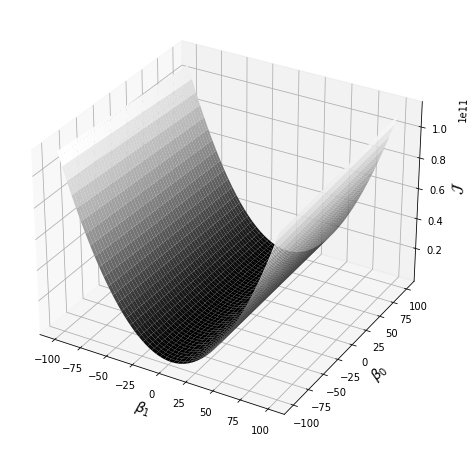

In [24]:
fig, ax = plt.subplots(figsize=[12, 8], subplot_kw={'projection': '3d'})
ax.plot_surface(b1_grid, b0_grid , J_cand_grid, cmap=cm.gray)
ax.set_ylabel(r'$\beta_0$', fontsize=14)
ax.set_xlabel(r'$\beta_1$', fontsize=14)
_ = ax.set_zlabel(r'$\mathcal{J}$', fontsize=14)

Seems like there is some pattern that we could follow: At both ends of this surface, the values of the cost function $\mathcal{J}$ are large. When we are searching on this grid, isn't this just like we are trying to navigate from taller positions to lower positions? What we just did was to walk on every cell on this grid and computed the mean squared error given the regression parameters within that cell. This is certainly acceptable in a small dataset and a simple problem. Is there any faster approach?

Luckily, there is a one! Recall that on a curve, the gradient on a certain point refers to the direction of change. We can apply this into the context of searching for satisfactory parameters to fit our data well. Specficically, no matter where we start on this grid, we can reach our destination faster if we follow the gradient! This is in fact the famous gradient descent, a commonly adopted approach for searching (local) optimum amongh the parameter space.

Given that there are two parameters in our context, we can do partial derivatives for each one at a time:

$$
\begin{align}
 \frac{\partial\mathcal{J}}{\partial\beta_1} = \frac{\Sigma_{i}^{N} x_i(\beta_1x_i+\beta_0-y_i)}{N} = -\frac{\Sigma_{i}^{N} x_i\epsilon_i}{N}  &&  \frac{\partial\mathcal{J}}{\partial\beta_0} = \frac{\Sigma_{i}^{N} (\beta_1x_i+\beta_0-y_i)}{N} =-\frac{\Sigma_{i}^{N} \epsilon_i }{N}
\end{align}
$$

So this is the direction we are going - everytime we are at a cell position over the grid of possible parameters, we will go against the direction so that we can reach the lower point, i.e., lower cost function value compared to the current position:

$$
\begin{align}
 \beta_1 := \beta_1 - \frac{[-\Sigma_{i}^{N} x_i\epsilon_i]}{N} &&  \beta_0 :=\beta_0-\frac{[-\Sigma_{i}^{N} \epsilon_i ]}{N}
\end{align}
$$

Let's try it!

In [25]:
# start at a random point
b1 = np.random.choice(beta_1_cand)
b0 = np.random.choice(beta_0_cand)
print('The starting point is: (%.3f, %.3f)'%(b1, b0))

The starting point is: (-59.799, 12.563)


let's first try a fixed number of iterations since we are not sure if this approach is going to work out or not

In [26]:
N_iter = 10
b1_list = list()
b0_list = list()
j_list = list()
for iter_ in range(N_iter+1):
    y_iter = b1*x + b0
    e_iter = y - y_iter
    j_iter = ((y-y_iter)**2).sum()/2
    b1_list.append(b1)
    b0_list.append(b0)
    j_list.append(j_iter)
    print('Iter %i at (%.3f, %.3f): %.3f'%(iter_, b1, b0, j_iter/1e5))
    # compute gradient
    b1 = b1 + (x * e_iter).sum()/N
    b0 = b0 + e_iter.sum()/N

Iter 0 at (-59.799, 12.563): 397038.456
Iter 1 at (237076.387, 3801.218): 6075834493374.263
Iter 2 at (-927413875.639, -14816909.892): 92977842148338991104.000
Iter 3 at (3627942152066.805, 57962192074.592): 1422829924019317979484258304.000
Iter 4 at (-14192114861613828.000, -226741787184222.875): 21773413384395116539573720387158016.000
Iter 5 at (55518008778210484224.000, 886989194635797248.000): 333196204553060290682976971236810497720320.000
Iter 6 at (-217180408188083424460800.000, -3469805196346075381760.000): 5098865702340089318501435276048680305556027604992.000
Iter 7 at (849586120589660007107133440.000, 13573500301245199048245248.000): 78027393755500928809648286678493339684161792543152930816.000
Iter 8 at (-3323488441339953209143667458048.000, -53098055943290371279511617536.000): 1194044819317719245881914070300577384770318951773401590504882176.000
Iter 9 at (13001125079649407976600801778860032.000, 207713816066895248741868289130496.000): 18272339519721184655824060771169413044771

Hmm... the model is not converging. In fact, it is getting worse. Is it possible that we might be going too fast such that we are always skipping around and move up in the surface? Obviously, from the previous visulization, the cost value $\mathcal{J}$ is expected to go much higher when the two parameters get extremely small or large in values.

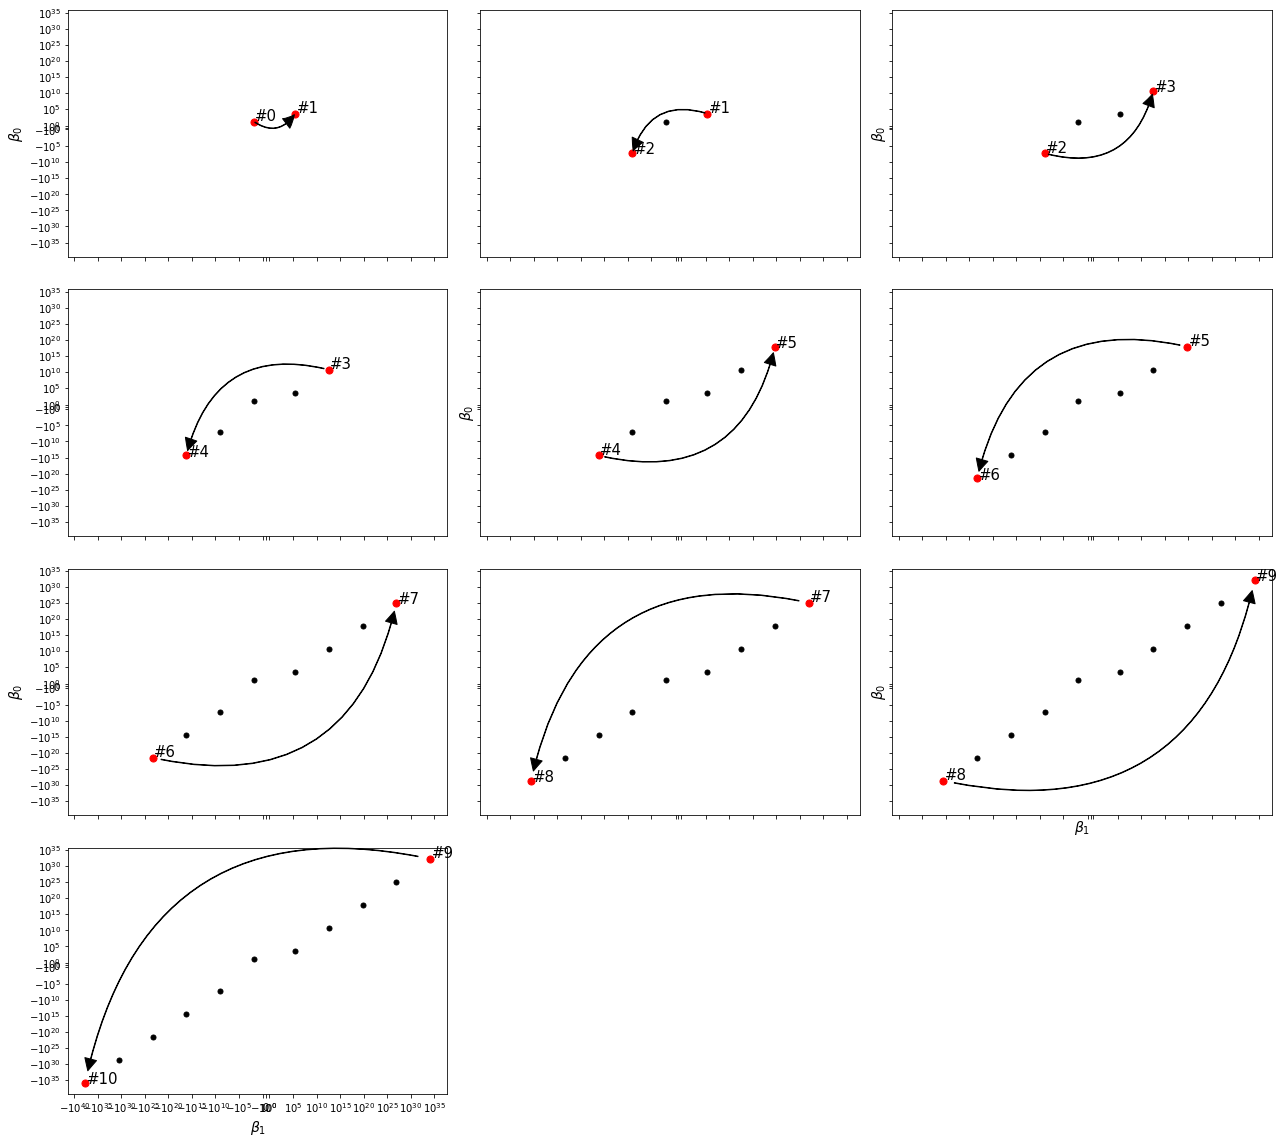

In [27]:
nrows = 4
ncols = int(np.ceil(N_iter / nrows))
fig, ax_arr = plt.subplots(figsize=[6*ncols, 4*nrows],
                           sharex=True, sharey=True,
                           nrows=nrows, ncols=ncols)
text_offset = 2
# add annotation and arrows
for i in range(N_iter):
    ax = ax_arr.flat[i]
    b1_i, b0_i = b1_list[i], b0_list[i]
    ax.scatter(b1_i, b0_i, marker='.',
               s=200, color='r')
    ax.scatter(b1_list[:i], b0_list[:i],
               marker='.', s=100, color='k')
    if b1_i < 0:
        b1_x = b1_i/text_offset
    else:
        b1_x = b1_i*text_offset
    if b0_i < 0:
        b0_x = b0_i/text_offset
    else:
        b0_x = b0_i*text_offset
    ax.annotate('#%i'%i, [b1_x, b0_x], fontsize=15)
    # now add arrows
    if i <= N_iter and i>=0:
        b1_i_1, b0_i_1 = b1_list[i+1], b0_list[i+1]
        ax.scatter(b1_i_1, b0_i_1, marker='.',
                   s=200, color='r')
        if b1_i_1 < 0:
            b1_x = b1_i_1/text_offset
        else:
            b1_x = b1_i_1*text_offset
        if b0_i < 0:
            b0_x = b0_i_1/text_offset
        else:
            b0_x = b0_i_1*text_offset
        ax.annotate('#%i'%(i+1), [b1_x, b0_x], fontsize=15)
        ax.annotate("", xy=(b1_i_1, b0_i_1), xytext=(b1_i, b0_i),
                    arrowprops=dict(connectionstyle="arc3,rad=.5",
                                    color='k',
                                    width=0.5, shrink=0.03))
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    if i%2 == 0:
        ax.set_ylabel(r'$\beta_0$', fontsize=14)
    if i > 7:
        ax.set_xlabel(r'$\beta_1$', fontsize=14)
for i in range(N_iter, ax_arr.size):
    ax_arr.flat[i].set_visible(False)
fig.tight_layout()

Alright, it is now very clear that our gradient descent goes too fast such that the beta's are going too big.
Let's try make our update on the two parameters to be slower.
An intuitive approach to do this is to assign a _learning rate_ (`alpha`) to discount the step size:

$$
\begin{align}
 \beta_1 := \beta_1 - \alpha \frac{[-\Sigma_{i}^{N} x_i\epsilon_i]}{N} &&  \beta_0 :=\beta_0-\alpha\frac{[-\Sigma_{i}^{N} \epsilon_i ]}{N}
\end{align}
$$

In [28]:
# start at a random point
alpha = 1e-4
b1 = np.random.choice(beta_1_cand)
b0 = np.random.choice(beta_0_cand)
print('The starting point is: (%.3f, %.3f)'%(b1, b0))

The starting point is: (34.673, -48.744)


In [29]:
N_iter = 10
b1_list = list()
b0_list = list()
j_list = list()
for iter_ in range(N_iter+1):
    y_iter = b1*x + b0
    e_iter = y - y_iter
    j_iter = ((y-y_iter)**2).sum()/2
    b1_list.append(b1)
    b0_list.append(b0)
    j_list.append(j_iter)
    print('Iter %i at (%.3f, %.3f): %.3f'%(iter_, b1, b0, j_iter/1e5))
    # compute gradient
    b1 = b1 + alpha*(x * e_iter).sum()/N
    b0 = b0 + alpha*e_iter.sum()/N

Iter 0 at (34.673, -48.744): 116763.323
Iter 1 at (21.814, -48.949): 43264.440
Iter 2 at (13.986, -49.074): 16030.977
Iter 3 at (9.221, -49.150): 5940.191
Iter 4 at (6.320, -49.197): 2201.263
Iter 5 at (4.555, -49.225): 815.882
Iter 6 at (3.480, -49.242): 302.558
Iter 7 at (2.826, -49.252): 112.357
Iter 8 at (2.428, -49.259): 41.881
Iter 9 at (2.185, -49.263): 15.768
Iter 10 at (2.038, -49.265): 6.093


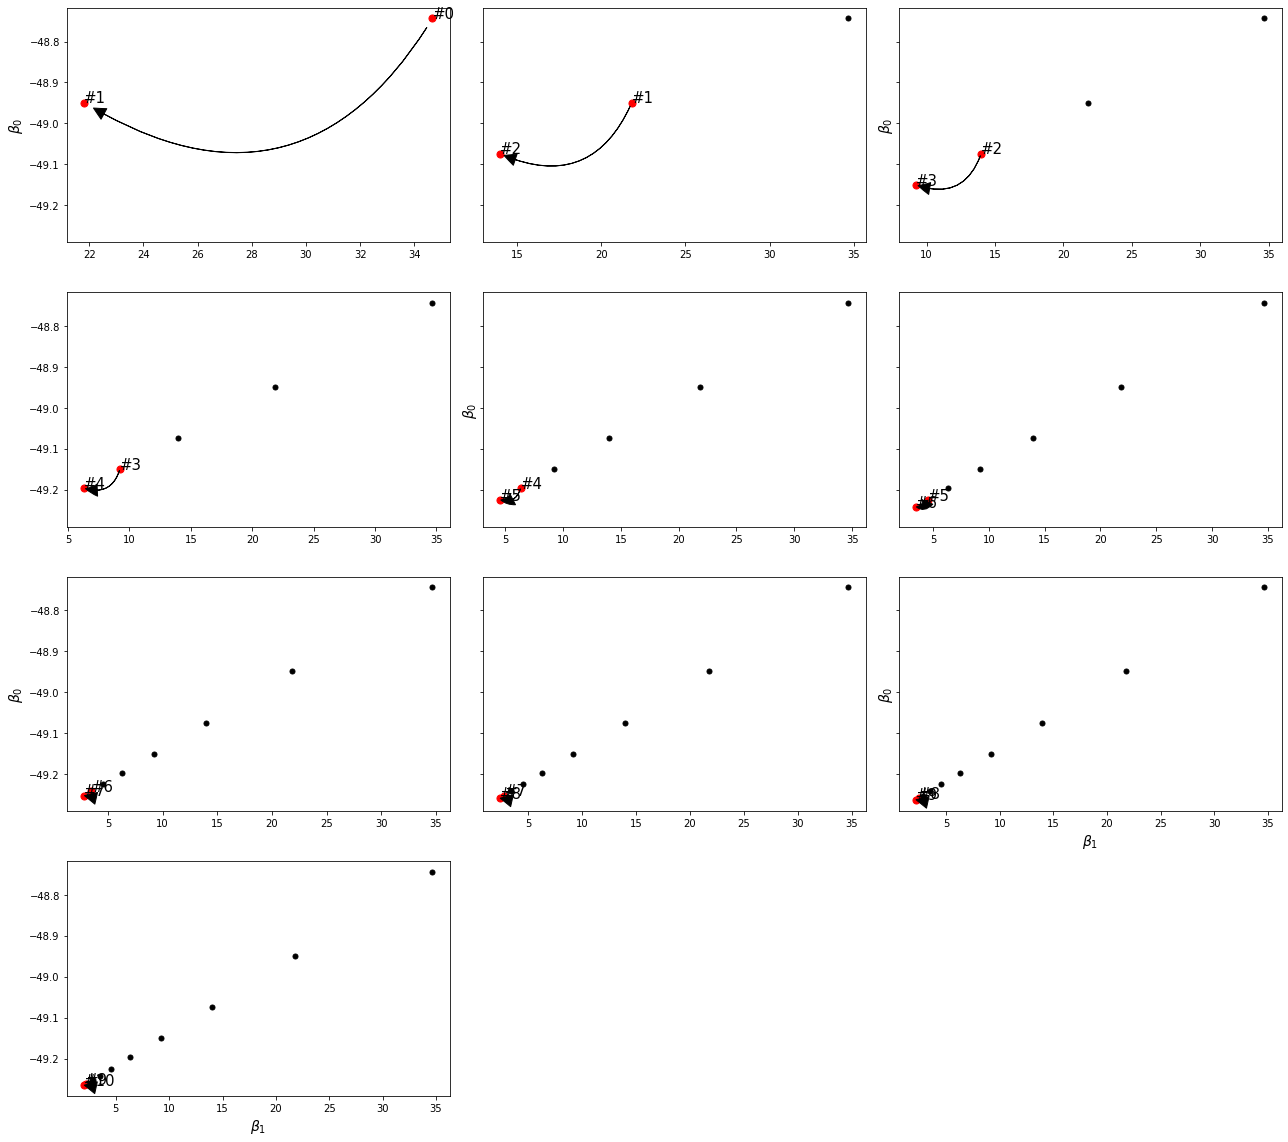

In [30]:
nrows = 4
ncols = int(np.ceil(N_iter / nrows))
fig, ax_arr = plt.subplots(figsize=[6*ncols, 4*nrows],
                           sharex=False, sharey=True,
                           nrows=nrows, ncols=ncols)
text_offset = 1
# add annotation and arrows
for i in range(N_iter):
    ax = ax_arr.flat[i]
    b1_i, b0_i = b1_list[i], b0_list[i]
    ax.scatter(b1_i, b0_i, marker='.',
               s=200, color='r')
    ax.scatter(b1_list[:i], b0_list[:i],
               marker='.', s=100, color='k')
    if b1_i < 0:
        b1_x = b1_i/text_offset
    else:
        b1_x = b1_i*text_offset
    if b0_i < 0:
        b0_x = b0_i/text_offset
    else:
        b0_x = b0_i*text_offset
    ax.annotate('#%i'%i, [b1_x, b0_x], fontsize=15)
    # now add arrows
    if i <= N_iter and i>=0:
        b1_i_1, b0_i_1 = b1_list[i+1], b0_list[i+1]
        ax.scatter(b1_i_1, b0_i_1, marker='.',
                   s=200, color='r')
        if b1_i_1 < 0:
            b1_x = b1_i_1/text_offset
        else:
            b1_x = b1_i_1*text_offset
        if b0_i < 0:
            b0_x = b0_i_1/text_offset
        else:
            b0_x = b0_i_1*text_offset
        ax.annotate('#%i'%(i+1), [b1_x, b0_x], fontsize=15)
        ax.annotate("", xy=(b1_i_1, b0_i_1), xytext=(b1_i, b0_i),
                    arrowprops=dict(connectionstyle="arc3,rad=-.5",
                                    color='k',
                                    width=0.1, shrink=0.03))
    if i%2 == 0:
        ax.set_ylabel(r'$\beta_0$', fontsize=14)
    if i > 7:
        ax.set_xlabel(r'$\beta_1$', fontsize=14)
for i in range(N_iter, ax_arr.size):
    ax_arr.flat[i].set_visible(False)
fig.tight_layout()

Great! So we could confidently try more iterations and set a convergence threshold for the parameter search to stop. Rather than manually setting a fixed number of iterations, we could use a `while` loop which will break when parameter changes are too small.

In [31]:
# start at a random point
alpha = 1e-4
thres = 1e-5 # convergence threshold
max_iter = int(1e3) # maximum iterations
b1 = np.random.random()
b0 = np.random.randint(10, 80)
print('The starting point is: (%.3f, %.3f)'%(b1, b0))

The starting point is: (0.065, 71.000)


In [32]:
b1_list = list()
b0_list = list()
j_list = list()
iter_ = 0
while True:
    y_iter = b1*x + b0
    e_iter = y - y_iter
    j_iter = ((y-y_iter)**2).sum()/2
    b1_list.append(b1)
    b0_list.append(b0)
    j_list.append(j_iter)
    if iter_%10 == 0:
        print('Iter %i at (%.3f, %.3f): %.3f'%(iter_, b1, b0, j_iter/1e5))
    # compute gradient
    grad_0 = -alpha*e_iter.sum()/N
    grad_1 = -alpha*(x * e_iter).sum()/N
    b1 -= grad_1
    b0 -= grad_0
    if (np.abs(grad_0) <= thres and np.abs(grad_1) <= thres) or iter_>=max_iter:
        print('Converged as of Iteration #%i or max iter reached'%iter_)
        print('b1=%.3f; b0=%.3f'%(b1, b0))
        break
    iter_ += 1

Iter 0 at (0.065, 71.000): 3.652
Iter 10 at (-0.112, 70.997): 0.211
Converged as of Iteration #18 or max iter reached
b1=-0.113; b0=70.997


In [33]:
step_size = 5
offset = 3
cmap_seq = sns.color_palette('Greens', n_colors=(len(b1_list)//step_size+offset)*2)[offset-1::2]
len(cmap_seq)

5

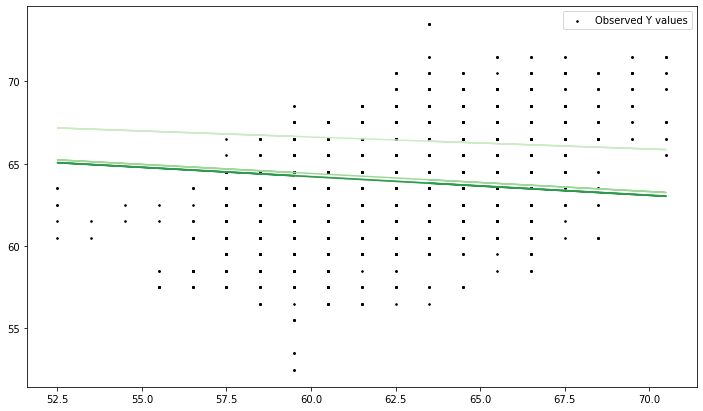

In [34]:
fig, ax = plt.subplots(figsize=[12, 7])
for i, index in enumerate(np.arange(offset, len(b1_list), step_size)):
    b1_i, b0_i = b1_list[index], b0_list[index]
    y_i = x * b1_i + b0_i
    ax.plot(x, y_i, color=cmap_seq[i])
ax.scatter(x, y, marker='.', s=10, color='k', label='Observed Y values')
_ = ax.legend()

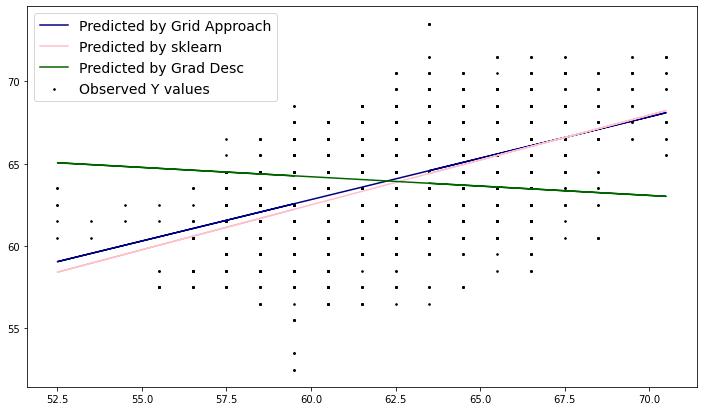

In [35]:
fig, ax = plt.subplots(figsize=[12, 7])
y_grid = x * beta_grid[0] + beta_grid[1]
y_grad_desc = x * b1 + b0
ax.plot(x, y_grid, color='navy', label='Predicted by Grid Approach')
ax.plot(x, y_pred, color='pink', label='Predicted by sklearn')
ax.plot(x, y_grad_desc, color='darkgreen', label='Predicted by Grad Desc')
ax.scatter(x, y, marker='.', s=10, color='k', label='Observed Y values')
_ = ax.legend(prop={'size': 14})

## Is there a best way? MLE and its equivalence to least square

Whereas gradient descent helps to speed up our search, we are not really sure whether that's the right line. Based on the above plot, we may in fact find that that's not very good. Indeed, the quality of gradient descent depends on many factors such as step size (we may further make our learning rate smaller as we proceed), initial starting point, etc.

Now, the question is, can we actually find the best parameters? If we rethink what wer are doing, we are basically trying to lower the objective function

$$ min \mathcal{J}(\beta_1,\beta_0) = min~\frac{1}{2}\Sigma_{i}^{N}[y_i-(\beta_1x_i+\beta_0)]^2$$

Based on our preivous logic, we are basically trying to ask our model to produce high quality prediction when it is fed with those data points. In other words, we are maximizing the likelihood of us seeing such pattern using a set of model parameters. From a probablistic perspecitve, we can formulate the problem into the maximization of the following probability

$$ p(y\vert \theta) = p(y\vert x,~\beta_1,~\beta_0)$$ 

Moreover, our error term is assumed to follow a Gaussian distribution centered at zero such that:

$$ \epsilon \sim \mathcal{N}(0, \sigma^2)$$
$$ y \vert x,~\beta_1,~\beta_0 \sim \mathcal{N}(\beta_1x+\beta_0, \sigma^2)$$

We can therefore further our equation as follows:

$$
\begin{align}
p(y\vert \theta) &= p(y\vert x,~\beta_1,~\beta_0) \\
&= \prod_{i} \frac{1}{\sqrt{2\pi\sigma^2}} exp\Big[ -\frac{(y_i-\beta_1x_i-\beta_0)^2}{2\sigma^2} \Big] \\
\end{align}
$$ 

To make things easier, a smart trick is to use the logarithm of the likelihood such that we can transform the multiplicative form into an additive one:

$$ 
\begin{align}
l(\theta) = \text{log}~\mathcal{L}(\theta) &= \text{log}~p(y\vert \theta) \\
&= \sum_i \text{log} \frac{1}{\sqrt{2\pi\sigma^2}} - \sum_i \frac{(y_i-\beta_1x_i-\beta_0)^2}{2\sigma^2} \\
&= -\frac{N}{2}\text{log} 2\pi\sigma^2 - \frac{1}{2\sigma^2} \sum_i (y_i-\beta_1x_i-\beta_0)^2 \\
&= -\frac{N}{2}\text{log} 2\pi\sigma^2 - \frac{1}{\sigma^2} \mathcal{J}
\end{align}
$$

Now it is clear that the log-likelihood function in fact leads us back to our previous formulation as __least square__:
<center>When we try to maximize the likelihood, we are also minizing the least square objective function.</center>

Recall that from calculus, when we are trying to reach the minimum, we can compute partial derivatives of the parameters and set them to zero, from which the optimal parameters can be computed.

$$
\begin{align}
\frac{\partial l}{\partial \beta_0}&=\frac{1}{\sigma^2} \frac{\partial \mathcal{J}}{\partial \beta_0} \\
&= \frac{1}{2\sigma^2} 2\sum_i(y_i-\beta_1x_i-\beta_0) = 0 \\
&  ~~~~~~~~~~~~~~~~~~ \Downarrow
\end{align}
$$

$$
\begin{align}
\sum_i\beta_0 &= \sum_i (y_i-\beta_1x_i) \\
N\beta_0 &=\sum_i (y_i-\beta_1x_i) \\
\beta_0 &=\frac{\sum_i (y_i-\beta_1x_i)}{N} \\
\beta_0 &=\bar{y}-\beta_1\bar{x} \\
\end{align}
$$

$$
\begin{align}
\frac{\partial l}{\partial \beta_1}&=\frac{1}{\sigma^2} \frac{\partial \mathcal{J}}{\partial \beta_1} \\
&= \frac{1}{2\sigma^2} 2\sum_i (-x_i) (y_i-\beta_1x_i-\beta_0) = 0 \\
&  ~~~~~~~~~~~~~~~~~~ \Downarrow
\end{align}
$$

$$
\begin{align}
\sum_i(x_i)(y_i-\beta_1x_i-\beta_0) &= 0 \\
\sum_i x_iy_i - \sum_i\beta_1x_i^2-\sum_i\beta_0x_i &= 0 \\
\beta_1\sum_ix_i^2 &= -\beta_0\sum_ix_i + \sum_i x_iy_i \\
\beta_1 &= \frac{-\beta_0\sum_ix_i + \sum_i x_iy_i}{\sum_ix_i^2}
\end{align}
$$

Replacing the equation of $\beta_0$ into that of $\beta_1$, we have:

$$
\begin{align}
\beta_1 &= \frac{-\beta_0\sum_ix_i + \sum_i x_iy_i}{\sum_ix_i^2} \\
\beta_1 &= \frac{-(\bar{y}-\beta_1\bar{x})\sum_ix_i + \sum_i x_iy_i}{\sum_ix_i^2}  \\
\beta_1\sum_ix_i^2 &= -\bar{y}\sum_ix_i+\beta_1\bar{x}\sum_ix_i + \sum_i x_iy_i  \\
\beta_1\sum_ix_i^2-\beta_1\bar{x}\sum_ix_i &= -\bar{y}\sum_ix_i + \sum_i x_iy_i  \\
\beta_1(\sum_ix_i^2-\bar{x}\sum_ix_i) &= -\bar{y}\sum_ix_i + \sum_i x_iy_i  \\
\beta_1 &= \frac{\sum_i x_iy_i - \bar{y}\sum_ix_i}{\sum_ix_i^2-\bar{x}\sum_ix_i}  \\
\end{align}
$$

Lastly, we can also obtain the value of $\sigma$:

$$
\begin{align}
%-\frac{N}{2}\text{log} 2\pi\sigma^2 - \frac{1}{\sigma^2} \mathcal{J} \\
\frac{\partial l}{\partial \sigma}&=  -\frac{N}{2}\frac{4\pi\sigma}{2\pi\sigma^2}+ \mathcal{J} \frac{d~\sigma^{-2}}{d~\sigma}\\
&= -\frac{N}{\sigma} + \sigma^{-3} \sum_i(y_i-\beta_1x_i-\beta_0)^2 = 0 \\
&  ~~~~~~~~~~~~~~~~~~ \Downarrow
\end{align}
$$

$$
\begin{align}
\frac{N}{\sigma} - \sigma^{-3} \sum_i(y_i-\beta_1x_i-\beta_0)^2 &= 0 \\
N\sigma^2 - \sum_i(y_i-\beta_1x_i-\beta_0)^2 &= 0 \\
\sigma^2 &= \frac{\sum_i(y_i-\beta_1x_i-\beta_0)^2}{N} \\
\end{align}
$$

Why don't we use these to check whether these make sense?

In [36]:
b1_mle = (x*y).sum() - y.mean()*x.sum()
b1_mle = b1_mle / ((x**2).sum() - x.mean()*x.sum())
b1_mle

0.5449367663860534

In [37]:
b0_mle = y.mean() - b1_mle*x.mean()
b0_mle

29.79840622059735

In [38]:
mother_daughter_heights_lr.coef_[0], mother_daughter_heights_lr.intercept_

(0.5449367663859608, 29.798406220603134)

This verifies that `sklearn` is likely using the same approach!

---

# Generalizing into multivariate cases

Once we are clear about the case for simple linear regression, we can easily adapt the same estimation strategy into the multivariate cases.

## Exercise time

Try to derive the MLE estimator for a linear regression model with two predictors (i.e., two independent variables). Upon obtaining the answer, do you find any patterns?

## Let's try to use regression for two variables

In [39]:
kidiq_url = 'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/KidIQ/data/kidiq.csv'
kidiq_dat = pd.read_csv(kidiq_url)
kidiq_dat.head(2)

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25


In [40]:
X = kidiq_dat.values[:, 1:3]
y = kidiq_dat.values[:, 0]

In [41]:
kidiq_lr = linear_model.LinearRegression().fit(X, y)

In [42]:
kidiq_lr.coef_

array([5.95011691, 0.56390605])

In [43]:
kidiq_lr.intercept_

25.731538175096034

When we have two, we are still able to visualize it using a surface

In [44]:
N_grid = 50
x1 = np.linspace(X[:,0].min(), X[:,0].max(), N_grid)
x2 = np.linspace(X[:,1].min(), X[:,1].max(), N_grid)
x1_grid, x2_grid = np.meshgrid(x1, x2)
x1_grid.shape, x2_grid.shape

((50, 50), (50, 50))

In [45]:
y_grid = np.ones(N_grid**2).reshape(*x1_grid.shape) * 1.
for i in range(N_grid):
    for j in range(N_grid):
        x1_i, x2_j = x1_grid[i, j], x2_grid[i, j]
        y_grid[i][j] = (kidiq_lr.coef_ * np.array([x1_i, x2_j])).sum() + kidiq_lr.intercept_
y_grid.shape

(50, 50)

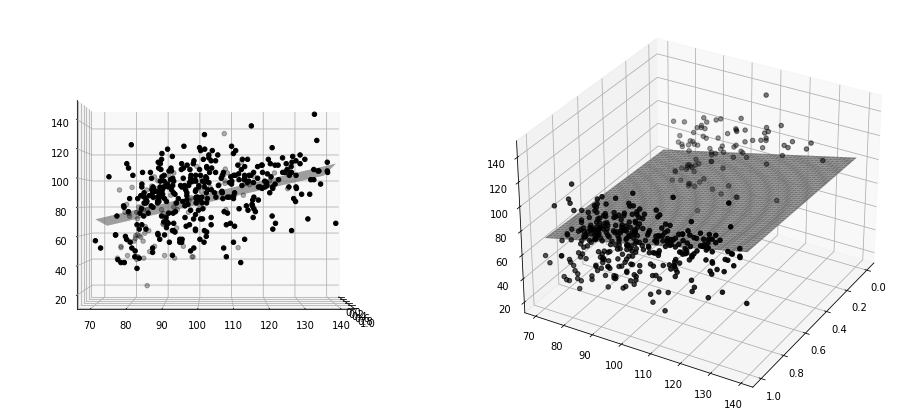

In [46]:
fig, (ax1, ax2) = plt.subplots(figsize=[16,10],
                               ncols=2,
                               subplot_kw={'projection': '3d'})
ax1.plot_surface(x1_grid, x2_grid, y_grid, color='gray')
ax1.scatter(X[:, 0], X[:, 1], y, color='k')
ax1.view_init(0, 0)
ax2.plot_surface(x1_grid, x2_grid, y_grid, color='gray')
ax2.scatter(X[:, 0], X[:, 1], y, color='k')
ax2.view_init(30, 30)

## Interpretation and caveats

Upon obtaining the regression result, how can we use it besides application in predicing unseen data points?

One common usage of the regression result is to look at the coefficients which are proxies of the __importance__ of feature contribution in prediction power of the model. Particularly, in a linear model such as linear regression, we know exactly how each feature helps to explain the variance in the target variable. Take our previous regression model as an example - the equation model is:

$$ \text{IQ} = 5.95\times \text{MomHighSchool} + 0.56\times \text{MomIQ} + 25.73$$

where:
- $\text{MomHighSchool}$ is a binary indicator referring to whether the mother of a given kid has attended high school or not. The coefficient is 5.95, meaning that the kid's IQ score increases by 5.95 if her mother attended school compare to the other whose mother did not, controlling for mother's IQ.
- $\text{MomIQ}$ is a continuous variable showing a kid's mother's IQ value. The coefficient is 0.56, meaning that the kid's IQ score increases 0.56 along with every unit increase in her mother's IQ, controlling for whether her mother attended high school or not.

However, can we say that $\text{MomHighSchool}$ is more predictive than $\text{MomIQ}$, since $5.95 > 0.56$? The answer is clearly no! It is very important to realize that the absolute value of regression coefficient does not necessarily reflect how "strong" a feature is. For this particular dataset, we can see that the two features are in different scales:

In [47]:
pd.DataFrame(X, columns=['MomHS', 'MomIQ']).describe().round(2)

,MomHS,MomIQ
count,434.00,434.00
mean,0.79,100.00
std,0.41,15.00
min,0.00,71.04
25%,1.00,88.66
50%,1.00,97.92
75%,1.00,110.27
max,1.00,138.89


Therefore, one unit change in $\text{MomIQ}$ means different things from $\text{MomHighSchool}$. A workaround to this is to __normalize__ the variables into the scale between 0 and 1 such that these variables are numerically similar in their scales. In fact, when we move to regularization, it is important we normalize the variables such that the penalty term can treat variables approximately similar to avoid issues such as penlty differ due to value but not its effect in predicion.

Alternatively, one can also estimate the predictive power by iteratively removing one variable at a time and compare their performance. Let us take this as an exercise: please find any one dataset with at least 4 features (independent variables) and compute the performance using all variables except for one at a time. Rank the variables based on the decreased performance when they are left out.

---

# Regression for prediction

## Generaliation error and cross validation

So far what we have been training a model with all the dataset. Whereas this is common in social sciences for explanatory purposes, such a practice does not help us understand how well a model serves to predict unseen data, which is effecitvely our main goal in building such a predictive model. More generally, the capability of a predictive model with regard to out-of-sample data is referred to as __generalizability__.

How do we estimate the generalization error then? A straightforward and intuitive approach is to make use of whatever we have in hand. Specifically, we could use one part of our data for training and the other for testing. However, only doing one random split does not provide representative splitting at all. Rather, we can _rotate_ the held-out part for testing so that the estimated generalization error is computed as the average prediction error on the multiple test sets. This process is known as __cross validation__.

For example, assume that we have 100 data points in total. Rather than using all 100 samples for training, we split them into 5 groups. In our first iteration, we can take the first 4 groups for training with the remaining group for testing and compute the testing error $\epsilon_{cv,1}$. In the second iteration, we repeat the previous process, except that our testing will be the second to the last group along with the first, second, third, and fifth group for training, computing the test error as $\epsilon_{cv,2}$. Eventually, the generalization of a given predictive model is  $\epsilon_{cv}=\frac{1}{5}\sum_{i\in\{1,2,3,4,5\}} \epsilon_{cv,i}$

In the following, we go through this process using `sklearn`:

In [48]:
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold

In [49]:
# use the California housing dataset as an example
X, y = datasets.fetch_california_housing(return_X_y=True)
X.shape, y.size

((20640, 8), 20640)

In [50]:
# check if there is any missing data
np.isnan(X).sum()

0

In [51]:
# split the dataset
kf = KFold(n_splits=10)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print('Fold %i: Training set of size %i, Testing set of size %i'%(i+1, train_index.size, test_index.size))

Fold 1: Training set of size 18576, Testing set of size 2064
Fold 2: Training set of size 18576, Testing set of size 2064
Fold 3: Training set of size 18576, Testing set of size 2064
Fold 4: Training set of size 18576, Testing set of size 2064
Fold 5: Training set of size 18576, Testing set of size 2064
Fold 6: Training set of size 18576, Testing set of size 2064
Fold 7: Training set of size 18576, Testing set of size 2064
Fold 8: Training set of size 18576, Testing set of size 2064
Fold 9: Training set of size 18576, Testing set of size 2064
Fold 10: Training set of size 18576, Testing set of size 2064


In [52]:
# use the split for train/test
kf = KFold(n_splits=10)
mse_list = list()
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    lr = linear_model.LinearRegression().fit(X_train, y_train)
    mse = metrics.mean_squared_error(y_test, lr.predict(X_test))
    mse_list.append(mse)
    print('Fold %i: %.3f'%(i+1, mse))
print('Generalization error across the 10 folds: %.3f ± %.3f'%(np.mean(mse_list), np.std(mse_list)))

Fold 1: 0.489
Fold 2: 0.433
Fold 3: 0.886
Fold 4: 0.391
Fold 5: 0.748
Fold 6: 0.530
Fold 7: 0.288
Fold 8: 0.773
Fold 9: 0.643
Fold 10: 0.328
Generalization error across the 10 folds: 0.551 ± 0.193


## Overfitting

As we can see previously, we may have a predictive model that fits the training data very well thanks to the high complexity model. Nonetheless, such a model is fine tuned towards the training data as well as the associated noise only and fails to capture the general trend. This is also known as __overfitting__. This usually happens when our model is overly compllicated and tries to fit the training data close to perfect. To illustrate this, let us use a synthetic data whose ground truth is known to us.

In [53]:
N = 20
X = np.linspace(0, 7, N)
y = np.sin(X) + np.random.normal(loc=0, scale=0.3, size=N)

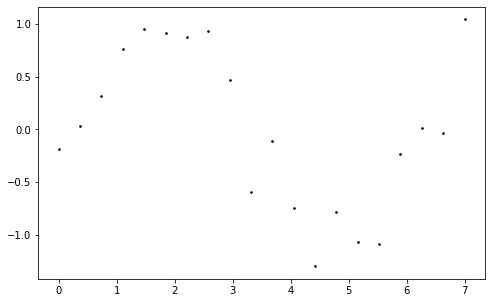

In [54]:
fig, ax = plt.subplots(figsize=[8,5])
ax.scatter(X, y, marker='.', color='k', s=10)

It is obvious that neither a linear nor a quadratic regression model is sufficient.

In [56]:
lr_1 = linear_model.LinearRegression().fit(X.reshape(-1, 1), y)
y_fit_1 = lr_1.predict(X.reshape(-1, 1))

Now try the linear model with an additional variable $x^2$ and $x^3$

In [57]:
from sklearn.preprocessing import PolynomialFeatures

In [58]:
poly_2 = PolynomialFeatures(degree=2)
X_2 = poly_2.fit_transform(X.reshape(-1,1))
lr_2 = linear_model.LinearRegression(fit_intercept=False).fit(X_2, y)
y_fit_2 = lr_2.predict(X_2)

In [59]:
poly_3 = PolynomialFeatures(degree=3)
X_3 = poly_3.fit_transform(X.reshape(-1,1))
lr_3 = linear_model.LinearRegression(fit_intercept=False).fit(X_3, y)
y_fit_3 = lr_3.predict(X_3)

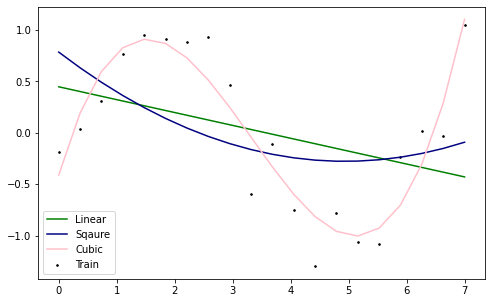

In [60]:
fig, ax = plt.subplots(figsize=[8,5])
ax.scatter(X, y, marker='.', color='k', s=10, label='Train')
ax.plot(X, y_fit_1, color='green', label='Linear')
ax.plot(X, y_fit_2, color='navy', label='Sqaure')
ax.plot(X, y_fit_3, color='pink', label='Cubic')
_ = ax.legend()

Given that it's highly nonlinear, can we try higher?

In [61]:
poly_6 = PolynomialFeatures(degree=6)
X_6 = poly_6.fit_transform(X.reshape(-1,1))
lr_6 = linear_model.LinearRegression(fit_intercept=False).fit(X_6, y)
y_fit_6 = lr_6.predict(X_6)

In [62]:
poly_9 = PolynomialFeatures(degree=9)
X_9 = poly_9.fit_transform(X.reshape(-1,1))
lr_9 = linear_model.LinearRegression(fit_intercept=False).fit(X_9, y)
y_fit_9 = lr_9.predict(X_9)

In [63]:
poly_12 = PolynomialFeatures(degree=12)
X_12 = poly_12.fit_transform(X.reshape(-1,1))
lr_12 = linear_model.LinearRegression(fit_intercept=False).fit(X_12, y)
y_fit_12 = lr_12.predict(X_12)

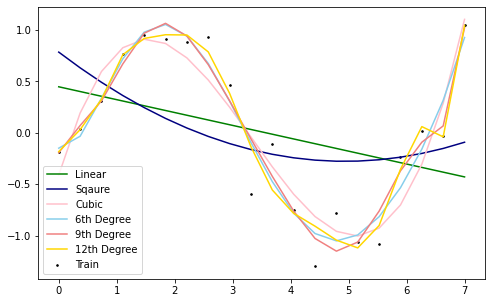

In [64]:
fig, ax = plt.subplots(figsize=[8,5])
ax.scatter(X, y, marker='.', color='k', s=10, label='Train')
ax.plot(X, y_fit_1, color='green', label='Linear')
ax.plot(X, y_fit_2, color='navy', label='Sqaure')
ax.plot(X, y_fit_3, color='pink', label='Cubic')
ax.plot(X, y_fit_6, color='skyblue', label='6th Degree')
ax.plot(X, y_fit_9, color='lightcoral', label='9th Degree')
ax.plot(X, y_fit_12, color='gold', label='12th Degree')
_ = ax.legend()

Visually we can see that when we have higher orders (more complex models), the fitted curve tries harder in capturing the _noise_ rather than the patterns (recall that we add Gaussian noises onto our data).

How should we deal with overftting? The first and probably great thing to do is to increase our data size - if we can have more training data, our complex models will behave better since patterns will overshado the noise. For example, we if we increase the sample size in this toy example:

In [65]:
N = 100
X = np.linspace(0, 7, N)
y = np.sin(X) + np.random.normal(loc=0, scale=0.3, size=N)

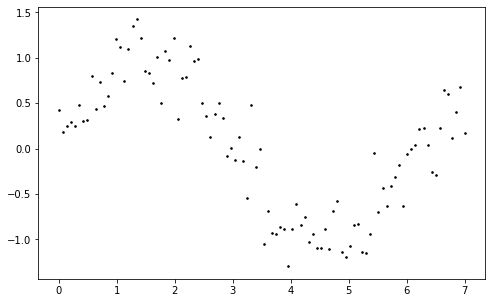

In [66]:
fig, ax = plt.subplots(figsize=[8,5])
ax.scatter(X, y, marker='.', color='k', s=10)

It is obvious that neither a linear nor a quadratic regression model is sufficient.

In [68]:
lr_1 = linear_model.LinearRegression().fit(X.reshape(-1,1), y)
y_fit_1 = lr_1.predict(X.reshape(-1, 1))

In [69]:
y_fit_list = list()
for deg in [2, 3, 6, 9, 12]:
    poly_i = PolynomialFeatures(degree=deg)
    X_i = poly_i.fit_transform(X.reshape(-1,1))
    lr_i = linear_model.LinearRegression(fit_intercept=False).fit(X_i, y)
    y_fit_i = lr_i.predict(X_i)
    y_fit_list.append(y_fit_i)

In [70]:
color_list = ['g', 'navy', 'pink', 'skyblue', 'lightcoral', 'gold']
legend_list = ['Linear', 'Square', 'Cubic', '6th', '9th', '12th']

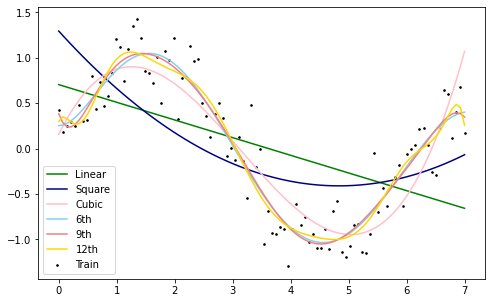

In [71]:
fig, ax = plt.subplots(figsize=[8,5])
ax.scatter(X, y, marker='.', color='k', s=10, label='Train')
for i, y_fit_i in enumerate([y_fit_1]+y_fit_list):
    ax.plot(X, y_fit_i, color=color_list[i], label=legend_list[i])
_ = ax.legend()

## Regularization

However, data is expensive. In many cases, we may have no access to more data. What workarounds can we use?

A different route to avoid overfitting our model is to alter our goal slightly -- rather than just minizing the mean squared error in our objective function, we should also add penalty when our model is complex. A popular approach is to add a second term in the objective function that penalizes the size of model paramters (the following formualation is for linear regression but can easily be adapted to other cases):

$$ \mathcal{J}(\beta) = ~\frac{1}{2}\Sigma_{i}^{N}[y_i-(\sum_j\beta_jx_{ij}+\beta_0)]^2 + \sum_j\lVert \beta_j \rVert^2 $$

From this new objective function, we can tell that the coefficients will be smaller compared to the case without such regularization term. In fact, such __shrinkage__ (this is more of a statistician term) helps us to prevent (complex) models from attending too much to noise. The linear regression with such a _L2 norm_ regularization is also known as __Ridge regression__.

To see how regularization helps, let's stick to the previous example

In [72]:
N = 20
X = np.linspace(0, 7, N)
y = np.sin(X) + np.random.normal(loc=0, scale=0.3, size=N)

In [73]:
# no regularization
poly_9 = PolynomialFeatures(degree=9)
X_9 = poly_9.fit_transform(X.reshape(-1,1))
lr_9 = linear_model.LinearRegression(fit_intercept=False).fit(X_9, y)
y_fit_9 = lr_9.predict(X_9)

In [74]:
np.array(lr_9.coef_.tolist() + [lr_9.intercept_]).sum()

1.0033379556424808

In [75]:
# ridge regression
lr_9_ridge = linear_model.Ridge(fit_intercept=False, alpha=1).fit(X_9, y)
y_fit_9_ridge = lr_9_ridge.predict(X_9)

In [76]:
np.array(lr_9_ridge.coef_.tolist() + [lr_9_ridge.intercept_]).sum()

0.8420550087369012

See that the size of the sum of coefficient L2 norms has decreased. The following visualization further reveals how regularization changes the resulting predictions. In this example, we can tell that the fitted curve with regularization does not try as hard to fit every single data point as the one without regularization

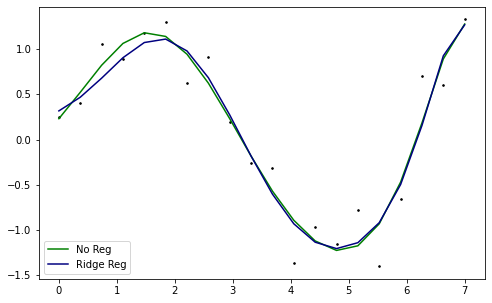

In [77]:
fig, ax = plt.subplots(figsize=[8,5])
ax.scatter(X, y, marker='.', color='k', s=10)
ax.plot(X, y_fit_9, color=color_list[0], label='No Reg')
ax.plot(X, y_fit_9_ridge, color=color_list[1], label='Ridge Reg')
_ = ax.legend()

In addition to Ridge regression, another type of regularized regressoin is called __Lasso regresion__ as well as __Elastic Net regression__. Please try these two methods using `sklearn` and see the differences beween these different regularization approaches after class.

---

# Other regression techniques using `sklearn`

Previously we have spent most of our time understanding the formulation of linear regression from the context of a single predictor to that of multiple predictors. Now it is time to move on to models that can handle data with more complex patterns.

## Generalized linear models

Our previous elaboration of linear regression model focuses on continuous target outcome such as height and score. In reality, we are faced with target outcome of different types. For instance, rather than predicting one's score, we may want to predict whether her score has passed a certain threshold. The target in this case is therefore a binary variable manifesting two levels, above or below the given threshold. This effectively makes the prediction problem a classification one rather than regression.

As another example, if we are predicting the number of vote in an election, our target variable is count. Compared to a continuous scale, a count variable does not have decimal points (in most of the cases). If we do not change our model setup, we may still be able to capture some patterns within the data. However, since count variable is fundamentally different from continuous values, we may also be faced with risks in making false assumptions about the data distribution that in turn leads to bad prediction performance.

To cater to various scenarios, we can in fact transform the outcome of the vanilla linear regression models to better fit the target variable's distribution. For instance, as we mention earlier, for a binary classification problem, we may use a binominal distritbuion to model the success probability. For count, we may make use of Poission distribution.

To turn this into a universal framework, the term __generalized linear model__ (GLM) was introduced. When we are encountered with different types of target variables, we just need to change the __link functions__ to better fit our data. Below we show an example modelling count data using Poission as the link fuction ([`sklearn`'s API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html))

In [78]:
# use a simulated data from https://stats.idre.ucla.edu/stat/data/poisson_sim.csv
url = "https://stats.idre.ucla.edu/stat/data/poisson_sim.csv"
data = pd.read_csv(url, index_col=0, header=0, names=['y', 'x1', 'x2'])
data.reset_index(drop=True, inplace=True)
data.head(2)

,y,x1,x2
0,0,3,41
1,0,1,41


In [79]:
data.shape

(200, 3)

In [80]:
X = data.loc[:, ['x1', 'x2']].values
y = data['y'].values

In [81]:
N = data.shape[0]
N_train = int(0.6*N)
index_train = np.random.choice(np.arange(N), replace=False, size=N_train)
index_test = np.array([idx for idx in np.arange(N) if idx not in index_train])
X_train, X_test = X[index_train], X[index_test]
y_train, y_test = y[index_train], y[index_test]

In [82]:
# try linear regression first
pr_lr = linear_model.LinearRegression().fit(X_train, y_train)
y_pred_lr = pr_lr.predict(X)

In [83]:
# try GLM with poission link
pr_glm = linear_model.PoissonRegressor().fit(X_train, y_train)
y_pred_glm = pr_glm.predict(X)

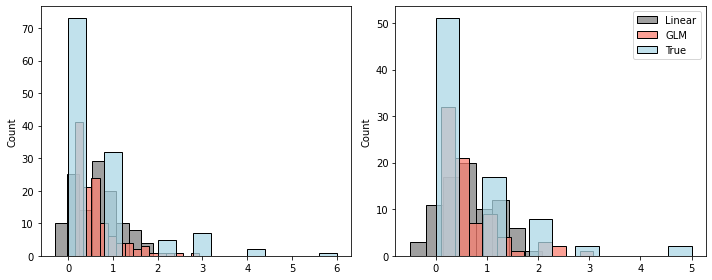

In [84]:
fig, (ax_train, ax_test) = plt.subplots(figsize=[10, 4], ncols=2)
# train
sns.histplot(y_pred_lr[index_train], ax=ax_train, label='Linear', color='gray')
sns.histplot(y_pred_glm[index_train], ax=ax_train, label='GLM', color='salmon')
sns.histplot(y[index_train], ax=ax_train, label='True', color='lightblue')
# test
sns.histplot(y_pred_lr[index_test], ax=ax_test, label='Linear', color='gray')
sns.histplot(y_pred_glm[index_test], ax=ax_test, label='GLM', color='salmon')
sns.histplot(y[index_test], ax=ax_test, label='True', color='lightblue')
ax_test.legend()
fig.tight_layout()

## Non-parametric models using Gaussian Process as an example

So far the models we have discussed belong to the class of __parametric models__, in which a fixed set of parameters are given for pattern recognition. Such models place apriori assumptions on the underlying distributions such that a model training process can learn the patterns of the dataset by tunining the paramters of a given model. For instance, in our linear regression model, we assume that the residual term follows a Gaussian distribution whose mean is a linear combination of the features (or independent variables). After the training, the $\beta$'s can be used to predict unseen data.

Another class of models is called __non-parametric models__, as you may guess.
This type of models frees us from making assumptions about the data and therefore grants much more flexibility. 
Below we provide an example of non-parametric models, namely Gaussian Process (GP) using scikit learn. In brief terms, GP sets out to model the predictive model itself -- it assumes that there is an infinite amount of functions. When fed with observations, GP will update the probabilities over the functions to best represent the data it is provided with.

Does this remind you of something? Yes! This is exactly how Bayesian statiscians think about decision making and/or hypothesis testing -- given a subject, we have some prior belief based on our past experience. When we are presented with more evidence, we will revise our belief accordingly. The mathematical formulation of this belief update process is the famous Bayes theorem:
$$p(\theta\vert \mathcal{D})=\frac{p(\theta,\mathcal{D})}{p(\mathcal{D})}=\frac{p(\mathcal{D}\vert\theta)p(\theta)}{p(\mathcal{D})}$$

When it comes to prediction, GP compares unseen data with what it has seen in training. The predicted value of a test data point is essentially the weighted average of the target values of observed data, with weights proportional to their distance (note that distance may be quantified by various measurements termed as kernel functions). Consequently, when there is more data available, the number of parameters governing GP will also increase.

The following example is based on `sklearn`'s introductory code [here](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html). You are strongly encouraged to play with the model by varying the kernels to see how predictions may vary.

In [95]:
# generate synthetic data
N = 1000
X = np.linspace(0, 10, N)
# add some gaussian noise
y = (X*np.sin(X)) * (1+np.random.normal(loc=0, scale=0.1, size=N))

Now we split the data for training and testing purposes.

In [96]:
N_train = int(0.6*N)
index_train = np.random.choice(np.arange(N), replace=False, size=N_train)
index_test = np.array([idx for idx in np.arange(N) if idx not in index_train])
X_train, X_test = X[index_train], X[index_test]
y_train, y_test = y[index_train], y[index_test]
# Try use the following two lines to train GP. See what happens!
#X_train, X_test = X[:N_train], X[N_train:]
#y_train, y_test = y[:N_train], y[N_train:]

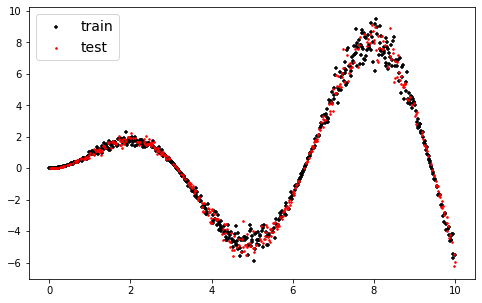

In [97]:
fig, ax = plt.subplots(figsize=[8,5])
ax.scatter(X_train, y_train, marker='+', s=10, color='k', label='train')
ax.scatter(X_test, y_test, marker='.', s=10, color='r', label='test')
_ = ax.legend(prop={'size': 14})

Fitting a GP regressor in `sklearn` is straightforward:

In [98]:
from sklearn import gaussian_process as SK_GP

In [99]:
kernel = SK_GP.kernels.RBF(length_scale=1, length_scale_bounds=[1e-3, 1e3])
kernel += SK_GP.kernels.WhiteKernel()

In [100]:
gp = SK_GP.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gp = gp.fit(X_train.reshape(-1, 1), y_train)
# generate prediction
y_pred, y_pred_std = gp.predict(X.reshape(-1 ,1), return_std=True)

We can see how flexible it could be!

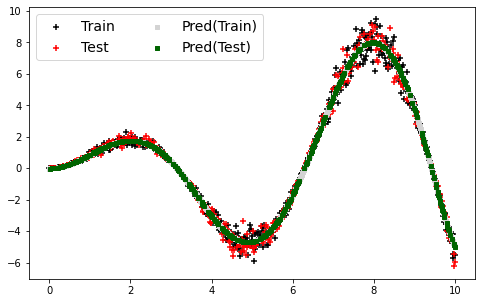

In [106]:
fig, ax = plt.subplots(figsize=[8,5])
ax.scatter(X_train, y_train, marker='+', s=30, color='k', label='Train')
ax.scatter(X_test, y_test, marker='+', s=30, color='r', label='Test')
ax.scatter(X[index_train], y_pred[index_train], marker='s', s=10,
           color='lightgray', label='Pred(Train)')
ax.scatter(X[index_test], y_pred[index_test], marker='s', s=10,
           color='darkgreen', label='Pred(Test)')
_ = ax.legend(prop={'size': 14}, ncol=2)

Since this is bayesian, we can also print out the uncertainty in GP's prediction

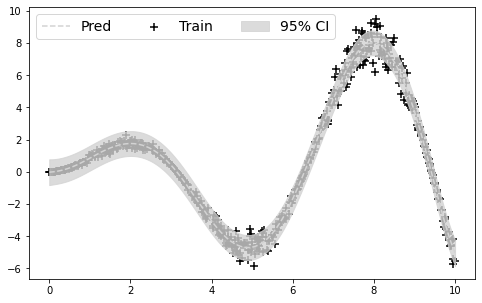

In [107]:
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(X, y_pred, color='lightgray', linestyle='--', label='Pred')
ax.scatter(X_train, y_train, color='k', marker='+', s=50, label='Train')
plt.fill_between(X, y_pred-1.96 * y_pred_std,
                 y_pred+1.96 * y_pred_std,
                 color='lightgray',
                 alpha=0.8, label=r"95% CI")
_ = ax.legend(prop={'size': 14}, ncol=3)

---

# Exercise Time

Please use the [insurance charge data](https://www.kaggle.com/mirichoi0218/insurance) for multivariate regression using:
1. Linear regression without regularization
2. Linear regression with L2 norm regulariaztion (ridge regression)
3. If you are interested, you can also try Gaussian process regression
    - You may want a sum-kernel by combining any kernel of your choice with a white noice kernel to capture individual level noise.

You are expected to:
- Use mean square error (MSE) as the evaluation metric.
- Hold out a random set of 20% data as the test set.
- Apply a 5-fold cross validation with the remaining data.
- Summarize the prediction results (both errors on the training and testing data).

---

# References

- Bishop, Christopher M. (2006). Pattern recognition and machine learning. New York :Springer.
- Gelman, A., Hill, J., & Vehtari, A. (2020). Regression and other stories. Cambridge University Press.
- Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.